# EAS Testing - Antutu benchmark on Android

The goal of this experiment is to run benchmarks on a Hikey running Android with an EAS kernel and collect results. The analysis phase will consist in comparing EAS with other schedulers, that is comparing *sched* governor with:

    - interactive
    - performance
    - powersave
    - ondemand
    
The benchmark we will be using is ***Antutu*** . You will need to **manually install** the app on the Android device in order to run this Notebook.

When opinening Antutu for the first time you will need to Install the work benchmark from inside the app.

In [32]:
import logging
reload(logging)
log_fmt = '%(asctime)-9s %(levelname)-8s: %(message)s'
logging.basicConfig(format=log_fmt)

# Change to info once the notebook runs ok
logging.getLogger().setLevel(logging.INFO)

In [33]:
%pylab inline

import copy
import os
from time import sleep
from subprocess import Popen
import pandas as pd

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Test Environment set up

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in `my_target_conf`. Run `adb devices` on your host to get the ID.

In [34]:
# Setup a target configuration
my_target_conf = {
    
    # Target platform and board
    "platform"    : 'android',

    # Add target support
    "board" : 'hikey',
    
    # Device ID
    #"device" : "00b1346f0878ccb1",
    
    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],
}

In [35]:
my_tests_conf = {

    # Folder where all the results will be collected
    "results_dir" : "Android_Antutu",

    # Platform configurations to test
    "confs" : [
        {
            "tag"            : "antutu",
            "flags"          : "ftrace",           # Enable FTrace events
            "sched_features" : "ENERGY_AWARE",     # enable EAS
        },
    ],
}

In [36]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

# Support Functions

This set of support functions will help us running the benchmark using different CPUFreq governors.

In [37]:
def set_performance():
    target.cpufreq.set_all_governors('performance')

def set_powersave():
    target.cpufreq.set_all_governors('powersave')

def set_interactive():
    target.cpufreq.set_all_governors('interactive')

def set_sched():
    target.cpufreq.set_all_governors('sched')

def set_ondemand():
    target.cpufreq.set_all_governors('ondemand')
    
    for cpu in target.list_online_cpus():
        tunables = target.cpufreq.get_governor_tunables(cpu)
        target.cpufreq.set_governor_tunables(
            cpu,
            'ondemand',
            **{'sampling_rate' : tunables['sampling_rate_min']}
        )

In [38]:
# CPUFreq configurations to test
confs = {
    'performance' : {
        'label' : 'prf',
        'set' :  set_performance,
    },
#    'powersave' : {
#        'label' : 'pws',
#        'set' :  set_powersave,
#    },
    'interactive' : {
         'label' : 'int',
         'set' :  set_interactive,
     },
    'sched' : {
        'label' : 'sch',
        'set' :  set_sched,
    },
#    'ondemand' : {
#        'label' : 'odm',
#        'set' :  set_ondemand,
#    }
}

# The set of results for each comparison test
results = {}

In [39]:
def check_packages(pkgname):
    try:
        output = target.execute('pm list packages -f | grep -i {}'.format(pkgname))
    except Exception:
        raise RuntimeError('Package: [{}] not availabe on target'.format(pkgname))

# Check for specified PKG name being available on target
#adb -s 0123456789 shell "am kill-all"
#adb -s 0123456789 shell "am start -W -n com.antutu.ABenchMark/.ABenchMarkStart"
#adb shell "am force-stop com.antutu.ABenchMark"
#check_packages('com.futuremark.pcmark.android.benchmark')
check_packages('com.antutu.ABenchMark')

In [40]:
def pcmark_run(exp_dir):
    # Unlock device screen (assume no password required)
    target.execute('input keyevent 82')
    # Start PCMark on the target device
#    target.execute('monkey -p com.futuremark.pcmark.android.benchmark -c android.intent.category.LAUNCHER 1')
    target.execute('am start -W -n com.antutu.ABenchMark/.ABenchMarkStart')
    # Wait few seconds to make sure the app is loaded
    sleep(5)
    
    # Flush entire log
    target.clear_logcat()
    
    # Run performance workload (assume screen is vertical)
    target.execute('input tap 512 200')
    # Wait for completion (7 minutes in total) and collect log
    log_file = os.path.join(exp_dir, 'log.txt')
    # Wait 5 minutes
    sleep(300)
    # Start collecting the log
    with open(log_file, 'w') as log:
        logcat = Popen(['adb logcat', 'com.antutu.ABenchMark/.ABenchMarkStart', '*:S'],
                       stdout=log,
                       shell=True)
        # Wait additional two minutes for benchmark to complete
        sleep(100)

        # Terminate logcat
        logcat.kill()

    # Get scores from logcat
    score_file = os.path.join(exp_dir, 'score.txt')
    os.popen('grep -o "PCMA_.*_SCORE .*" {} | sed "s/ = / /g" | sort -u > {}'.format(log_file, score_file))
    
    # Close application
    target.execute('am force-stop com.antutu.ABenchMark')
    
    return score_file

def antutu_run(exp_dir):
    !wa run antutu.yaml -f -d $exp_dir
    score_file = exp_dir+"/results.csv"
    print score_file
    

In [41]:
import csv
from collections import defaultdict

def experiment(governor, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    ### Run the benchmark ###
    #score_file = pcmark_run(exp_dir)
    score_file = antutu_run(exp_dir)
    
    # Save the score as a dictionary
    scores = dict()
    #with open(score_file, 'r') as f:
#        lines = f.readlines()
#        for l in lines:
#            info = l.split()
#            scores.update({info[0] : float(info[1])})

    inFile = open('/home/lubaoquan/tools/lisa/lisa/results/Android_PCMark/'+governor+'/results.csv', 'r')
    inLine = csv.reader(inFile)
    next(inLine, None)
    collectValue = defaultdict(list)
    for row in inLine:
        item = row[3]
        value = row[4]
#        collectValue[item].append(float(value))
#    for item, value in collectValue.iteritems():
        if item == 'execution_time':
            continue
        print item, value
        scores.update({item : float(value)})
    
    # return all the experiment data
    return {
        'dir'        : exp_dir,
        'scores'     : scores,
    }

# Run Antutu and collect scores

In [42]:
# Run the benchmark in all the configured governors
for governor in confs:
    test_dir = os.path.join(te.res_dir, governor)
    res = experiment(governor, test_dir)
    results[governor] = copy.deepcopy(res)

2016-11-21 19:55:29,971 INFO    : ------------------------
2016-11-21 19:55:29,973 INFO    : Run workload using performance governor


INFO     Removing existing output directory.
INFO     Creating output directory.
INFO     Initializing
INFO     Running workloads
INFO     Connecting to device
INFO     Initializing device
INFO     Initializing workloads
INFO     Running workload 1 antutu (iteration 1)
INFO     	Setting up
INFO     	Executing
INFO     	Processing result
INFO     	Tearing down
INFO     Finalizing workloads
INFO     Finalizing.
INFO     Processing overall results
INFO     Status available in /home/lubaoquan/tools/lisa/lisa/results/Android_PCMark/performance/status.txt
INFO     Done.
INFO     Run duration: 7 minutes 19 seconds
INFO     Ran a total of 1 iterations: 1 OK
INFO     Results can be found in /home/lubaoquan/tools/lisa/lisa/results/Android_PCMark/performance


2016-11-21 20:02:52,154 INFO    : ------------------------
2016-11-21 20:02:52,156 INFO    : Run workload using sched governor


/home/lubaoquan/tools/lisa/lisa/results/Android_PCMark/performance/results.csv
Overall_Score 15260
INFO     Removing existing output directory.
INFO     Creating output directory.
INFO     Initializing
INFO     Running workloads
INFO     Connecting to device
INFO     Initializing device
INFO     Initializing workloads
INFO     Running workload 1 antutu (iteration 1)
INFO     	Setting up
INFO     	Executing
INFO     	Processing result
INFO     	Tearing down
INFO     Finalizing workloads
INFO     Finalizing.
INFO     Processing overall results
INFO     Status available in /home/lubaoquan/tools/lisa/lisa/results/Android_PCMark/sched/status.txt
INFO     Done.
INFO     Run duration: 7 minutes 21 seconds
INFO     Ran a total of 1 iterations: 1 OK
INFO     Results can be found in /home/lubaoquan/tools/lisa/lisa/results/Android_PCMark/sched


2016-11-21 20:10:15,708 INFO    : ------------------------
2016-11-21 20:10:15,709 INFO    : Run workload using interactive governor


/home/lubaoquan/tools/lisa/lisa/results/Android_PCMark/sched/results.csv
Overall_Score 15114
INFO     Removing existing output directory.
INFO     Creating output directory.
INFO     Initializing
INFO     Running workloads
INFO     Connecting to device
INFO     Initializing device
INFO     Initializing workloads
INFO     Running workload 1 antutu (iteration 1)
INFO     	Setting up
INFO     	Executing
INFO     	Processing result
INFO     	Tearing down
INFO     Finalizing workloads
INFO     Finalizing.
INFO     Processing overall results
INFO     Status available in /home/lubaoquan/tools/lisa/lisa/results/Android_PCMark/interactive/status.txt
INFO     Done.
INFO     Run duration: 7 minutes 19 seconds
INFO     Ran a total of 1 iterations: 1 OK
INFO     Results can be found in /home/lubaoquan/tools/lisa/lisa/results/Android_PCMark/interactive
/home/lubaoquan/tools/lisa/lisa/results/Android_PCMark/interactive/results.csv
Overall_Score 15213


After running the benchmark for the specified governors we can show the scores

In [43]:
# Create results DataFrame
data = {}
for governor in confs:
    data[governor] = {}
    for score_name, score in results[governor]['scores'].iteritems():
        data[governor][score_name] = score
#df = pd.DataFrame.from_dict(data)
#df
#data['performance']['CPU']=12405
#data['interactive']['CPU']=11000
#data['performance']['GPU']=2434
#data['interactive']['GPU']=2100
#data['performance']['UX']=12939
#data['interactive']['UX']=11100
#data['performance']['RAM']=4358
#data['interactive']['RAM']=4100
df = pd.DataFrame.from_dict(data)
df

,interactive,performance,sched
Overall_Score,15213,15260,15114


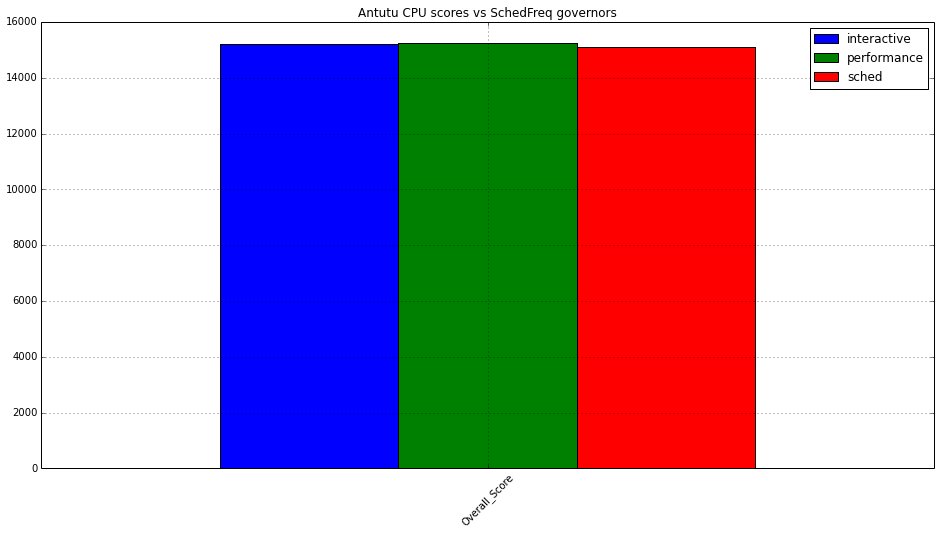

In [44]:
df.plot(kind='bar', rot=45, figsize=(16,8),
        title='Antutu CPU scores vs SchedFreq governors');